# Inital imports

In [2]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import PIL

seed = 777
np.random.seed(seed)
torch.manual_seed(seed)

# Hyper-Parameters for training

In [15]:
BATCH_SIZE = 32

# Check versions of crucial libraries

In [3]:
print(torch.__version__)
print(torchvision.__version__)
print(PIL.__version__)

1.3.1
0.4.2
6.2.1


# Data augmentation Functions

The following classes define different augmentation approaches.


# Imgaug-Augmentation

In [4]:
from imgaug import augmenters as iaa
import imgaug as ia

class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        #iaa.Resize((224, 224)),
        iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-20, 20), mode='symmetric'),
        iaa.Sometimes(0.25,
                      iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                 iaa.CoarseDropout(0.1, size_percent=0.5)])),
        iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
    ])
      
  def __call__(self, img):
    img = np.array(img)
    return self.aug.augment_image(img)

transform_imgaug = ImgAugTransform()

#dataset = torchvision.datasets.ImageFolder('pytorch-examples/data/', transform=transforms)

# Pytorch-Augmentation 

In [5]:
import PIL

transform_pytorch = torchvision.transforms.Compose([
    #torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR)
])

# Albumentations

In [6]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, Flip, OneOf, Compose
)

transform_albumentations = transforms.Compose([
        RandomRotate90(),
        Flip(),
        Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=.2),
            MedianBlur(blur_limit=3, p=.1),
            Blur(blur_limit=3, p=.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomContrast(),
            RandomBrightness(),
        ], p=0.3),
        HueSaturationValue(p=0.3),
    ])

# AutoAugment

rom AutoAugment.autoaugment import CIFAR10Policy
#from autoaugment import CIFAR10Policy
transform_autoaugment =transforms.Compose([
                         #transforms.RandomCrop(32, padding=4, fill=128), # fill parameter needs torchvision installed from source
                         #transforms.RandomHorizontalFlip(),
                         CIFAR10Policy(),  
                         #Cutout(n_holes=1, length=16), # (https://github.com/uoguelph-mlrg/Cutout/blob/master/util/cutout.py)
                         ])

In [7]:
from pytorchAutoAugment.auto_augment import AutoAugment
from pytorchAutoAugment.auto_augment import Cutout

transform_autoaugment = transforms.Compose([
    AutoAugment(),
    #Cutout(),
])


# Split in test and training set with applying of transforms

In [8]:
#The compose function allows for multiple transforms
#transforms.ToTensor() converts our PILImage to a tensor of shape (C x H x W) in the range [0,1]
#transforms.Normalize(mean,std) normalizes a tensor to a (mean, std) for (R, G, B)

transform_tensor_norm = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_imgaug_norm = transforms.Compose([transform_imgaug, transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_pytorch_norm = transforms.Compose([transform_pytorch, transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_albumentations_norm = transforms.Compose([transform_albumentations, transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_autoaugment_norm = transforms.Compose([transform_autoaugment, transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_set_norm = torchvision.datasets.CIFAR10(root='./cifardata', train=True, download=True, transform=transform_tensor_norm)
train_set_imgaug = torchvision.datasets.CIFAR10(root='./cifardata', train=True, download=True, transform=transform_imgaug_norm)
train_set_pytorch = torchvision.datasets.CIFAR10(root='./cifardata', train=True, download=True, transform=transform_pytorch_norm)
train_set_albumentations = torchvision.datasets.CIFAR10(root='./cifardata', train=True, download=True, transform=transform_albumentations_norm)
train_set_autoaugment = torchvision.datasets.CIFAR10(root='./cifardata', train=True, download=True, transform=transform_autoaugment_norm)


test_set = torchvision.datasets.CIFAR10(root='./cifardata', train=False, download=True, transform=transform_tensor_norm)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Concat datasets

In [86]:
#dataset_norm = train_set_norm + train_set_norm
dataset_norm = torch.utils.data.ConcatDataset((train_set_norm, train_set_norm))
dataset_imgaug = torch.utils.data.ConcatDataset((train_set_norm, train_set_imgaug))
dataset_pytorch = torch.utils.data.ConcatDataset((train_set_norm, train_set_pytorch))
dataset_autoaugment = torch.utils.data.ConcatDataset((train_set_norm, train_set_autoaugment))

#dataset_imgaug = train_set_norm + train_set_imgaug
#dataset_pytorch = train_set_norm + train_set_pytorch
#dataset_autoaugment = train_set_norm + train_set_autoaugment

In [87]:
print(dataset_norm.cumulative_sizes)
print(dataset_imgaug.cumulative_sizes)
print(dataset_pytorch.cumulative_sizes)
print(dataset_autoaugment.cumulative_sizes)

[50000, 100000]
[50000, 100000]
[50000, 100000]
[50000, 100000]


In [54]:
trainsets = {'norm' : dataset_norm, 'imgaug' : dataset_imgaug, 'pytorch' : dataset_pytorch, 'autoaugment' : dataset_autoaugment}


In [102]:


#DataLoader takes in a dataset and a sampler for loading (num_workers deals with system level memory) 
def get_train_loader(batch_size, train_set):
    
    #Training
    n_training_samples = 20000 # Number of training samples
    train_sampler = torch.utils.data.RandomSampler(train_set, replacement=True, num_samples=n_training_samples)
    
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=0)
    return(train_loader)

# Preprocess the data with augmentation.
To spare the augmentation from being applied on every loading during training, preprocessing is done once.
With this, the random effect of some augmentation is gone to a static one though.

In [105]:
parent_dir = './preprocessed_data'

PREPROCESS = True

if PREPROCESS:
    import os

    for key in trainsets:

        #Use the data loader to only load the subset of specified images
        train_loader = get_train_loader(BATCH_SIZE, trainsets[key])

        dirName = key

        try:
            # Create target Directory
            os.mkdir(parent_dir + '/' + dirName)
            print("Directory " , dirName ,  " Created ") 
        except FileExistsError:
            print("Directory " , dirName ,  " already exists")

        #Save the dataset batch-wise
        for idx, data in enumerate(train_loader, 0):
            torch.save(data, '{}/{}/{}'.format(parent_dir, key, idx))

    
    

Directory  norm  Created 
Directory  imgaug  Created 
Directory  pytorch  Created 
Directory  autoaugment  Created 


# Check the augmentation data sets by taking some sample plots

In [103]:

import matplotlib as mpl
import matplotlib.pyplot as plt
def plotSomeImages(n, dataiter, title):


    n_plots = n
    
    fig=plt.figure(figsize=(12, 10), dpi=80)

    for i in range(n_plots):

        images, labels = dataiter.next()

        img = images[0]
        img = img / 2 + 0.5     # unnormalize

        fig.add_subplot(4,4,i+1)
        plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))


    fig.suptitle(title, fontsize=16)
    plt.show()

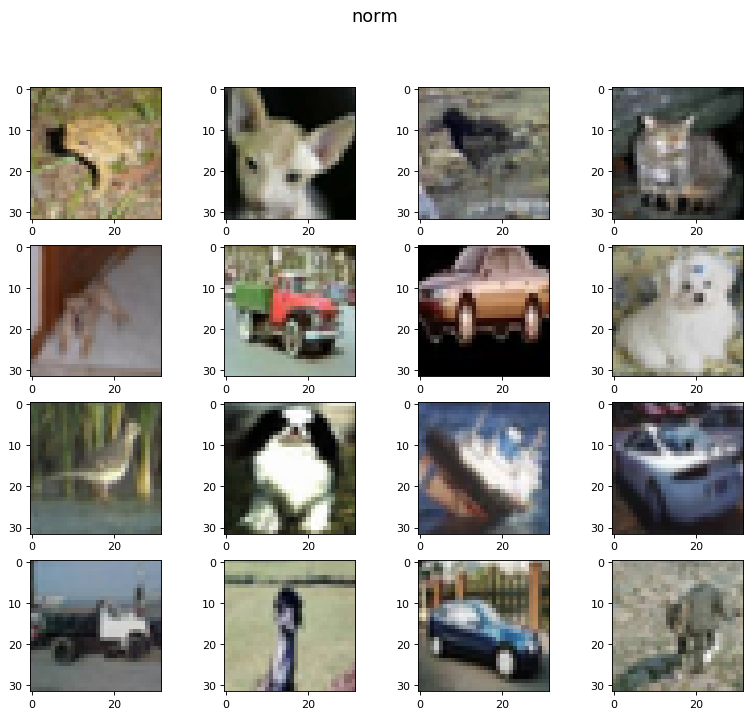

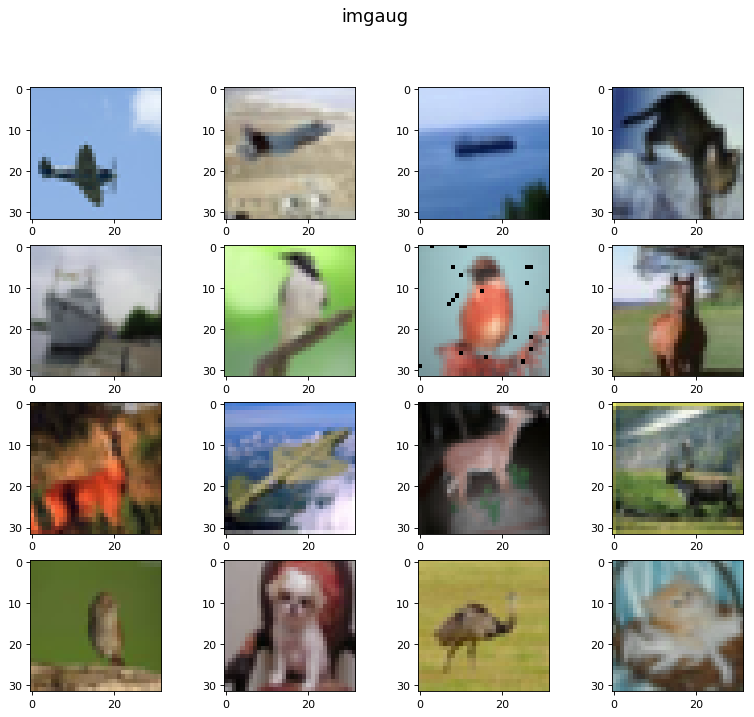

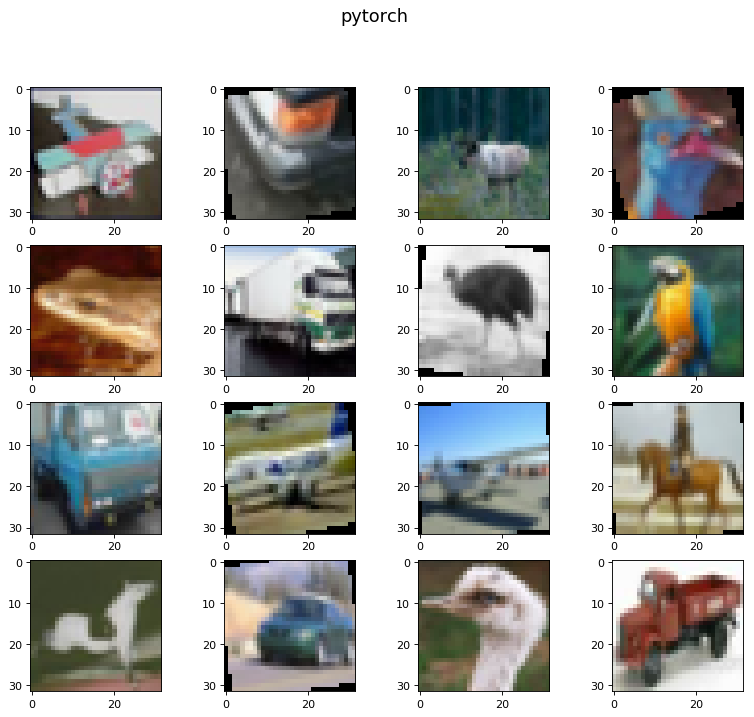

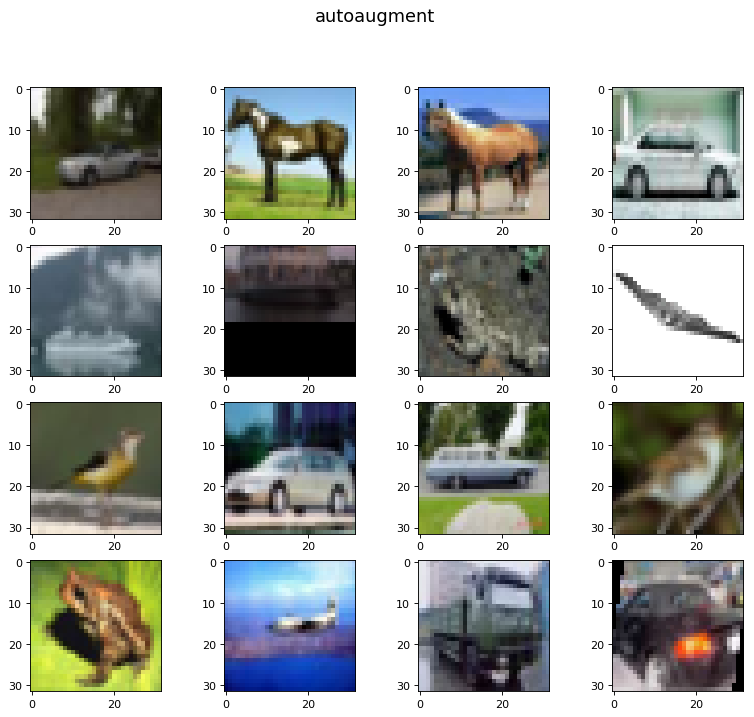

In [104]:


n=16

for key in trainsets:
    #print("Augmentation: " + key)
    loader = get_train_loader(1, trainsets[key])
    dataiter = iter(loader)
    plotSomeImages(n, dataiter, key)

# Train the same model with different augmentations

# Results compared

[ 10.  20.  30.  40.  50.  60.  70.  80.  90. 100.]


# TODO:

# Fragen